# Plant Classifier

Hey Everyone ! So I just watched the Lesson-1 video in Fast.ai's new v3 of Deep Learning for Coders, 2019 edition. I decided to create a world class classifier using just a few lines of code, as explained in the video. Here, I'm creating my own image dataset for plant classification. I took my mobile and clicked 10 pics of 10 different plants in my garden. Since, I'm very bad in identifying the different plants, I thought this image classifier model  would help me in identifying the different plants.

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate, accuracy

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [0]:
bs = 32
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

In [49]:
torch.cuda.is_available()

True

In [50]:
from google.colab import auth
auth.authenticate_user()

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'knowthetruth-ceed8'
!gcloud config set project {project_id}

Updated property [core/project].


In [57]:
# Download the file from a given Google Cloud Storage bucket.
!gsutil cp gs://knowthetruth-ceed8.appspot.com/plants.zip /content/plants.zip
  
# Print the result to make sure the transfer worked.
!ls /tmp/

Copying gs://knowthetruth-ceed8.appspot.com/plants.zip...
| [1 files][158.0 MiB/158.0 MiB]                                                
Operation completed over 1 objects/158.0 MiB.                                    


In [52]:
# Inspect the file we downloaded to /tmp
!ls -lt

total 161768
-rw-r--r-- 1 root root 165631034 Jan 29 12:52 plants.zip
-rw-r--r-- 1 root root      2513 Jan 29 12:52 adc.json
drwxr-xr-x 6 root root      4096 Jan 29 11:08 plants
drwxr-xr-x 1 root root      4096 Jan  8 17:15 sample_data


In [0]:
!unzip  /content/plants.zip 

In [59]:
!ls plants/ 


train  valid


## Looking at the data

In [109]:
data = ImageDataBunch.from_folder('/content/plants/', bs=bs, 
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)
data

ImageDataBunch;

Train: LabelList
y: CategoryList (482 items)
[Category tomato, Category tomato, Category tomato, Category tomato, Category tomato]...
Path: /content/plants
x: ImageItemList (482 items)
[Image (3, 250, 375), Image (3, 252, 280), Image (3, 681, 1024), Image (3, 600, 600), Image (3, 1000, 1000)]...
Path: /content/plants;

Valid: LabelList
y: CategoryList (194 items)
[Category tomato, Category tomato, Category tomato, Category tomato, Category tomato]...
Path: /content/plants
x: ImageItemList (194 items)
[Image (3, 376, 510), Image (3, 1000, 1000), Image (3, 710, 800), Image (3, 514, 935), Image (3, 335, 493)]...
Path: /content/plants;

Test: None

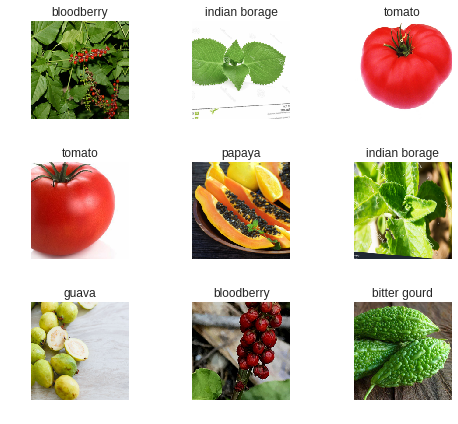

In [110]:
data.show_batch(rows=3, figsize=(7,6))

In [111]:
print(data.classes)
len(data.classes),data.c

['betel', 'bitter gourd', 'bloodberry', 'guava', 'indian borage', 'mango', 'mint', 'neem', 'papaya', 'tomato']


(10, 10)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [0]:
learn = create_cnn(data, models.resnet34, metrics=[accuracy,error_rate])

In [0]:
# learn.model

In [114]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,error_rate
1,1.770423,0.590840,0.824742,0.175258
2,1.083671,0.481485,0.845361,0.154639


In [0]:
learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [116]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

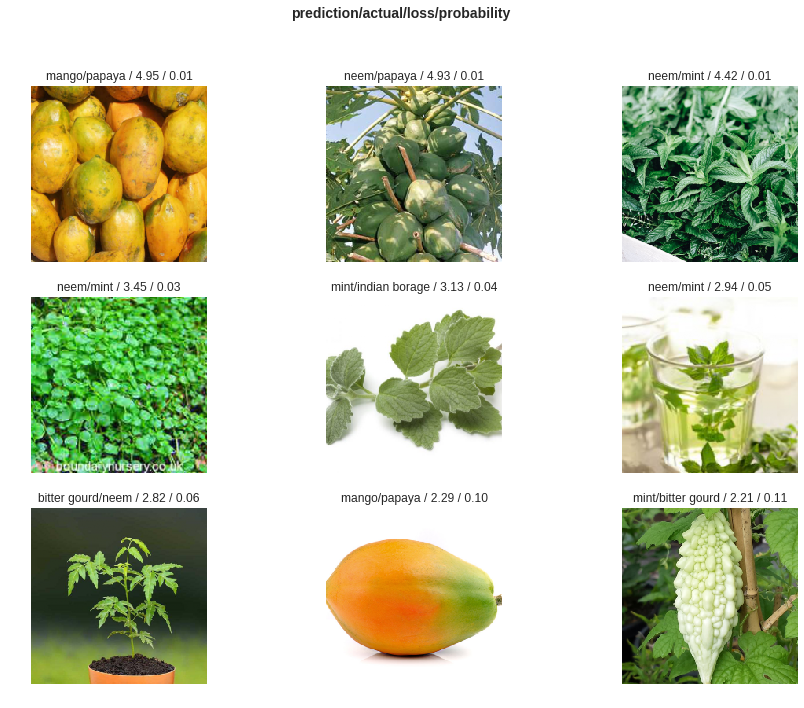

In [117]:
interp.plot_top_losses(9, figsize=(15,11))

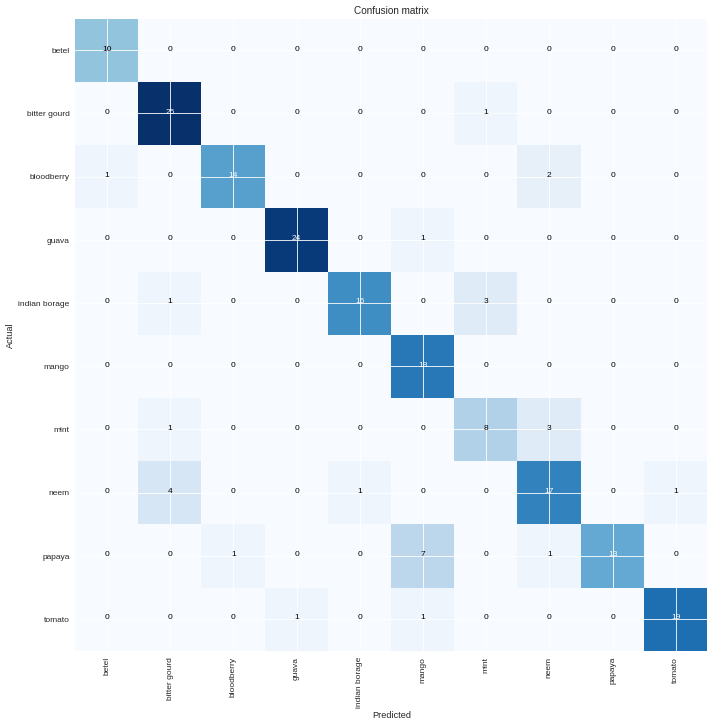

In [118]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [119]:
interp.most_confused(min_val=2)

[('papaya', 'mango', 7),
 ('neem', 'bitter gourd', 4),
 ('indian borage', 'mint', 3),
 ('mint', 'neem', 3)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [0]:
learn.unfreeze()

In [121]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,error_rate
1,0.484253,0.372690,0.896907,0.103093


In [0]:
learn.load('stage-1');

In [123]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


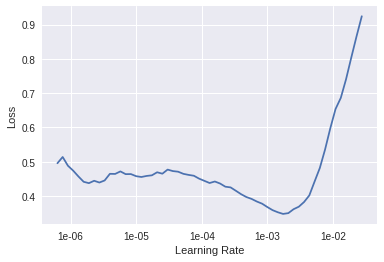

In [124]:
learn.recorder.plot()

In [125]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-04,1e-03))

epoch,train_loss,valid_loss,accuracy,error_rate
1,0.444259,0.466016,0.855670,0.144330
2,0.327753,0.385298,0.891753,0.108247


In [0]:
learn.save('stage-2')

That's a pretty accurate model!

In [0]:
learn.export()


In [128]:
!ls plants/

export.pkl  models  train  valid


In [0]:
learn = load_learner('/content/plants/')


In [106]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving indian borage1.jpg to indian borage1.jpg
User uploaded file "indian borage1.jpg" with length 231266 bytes


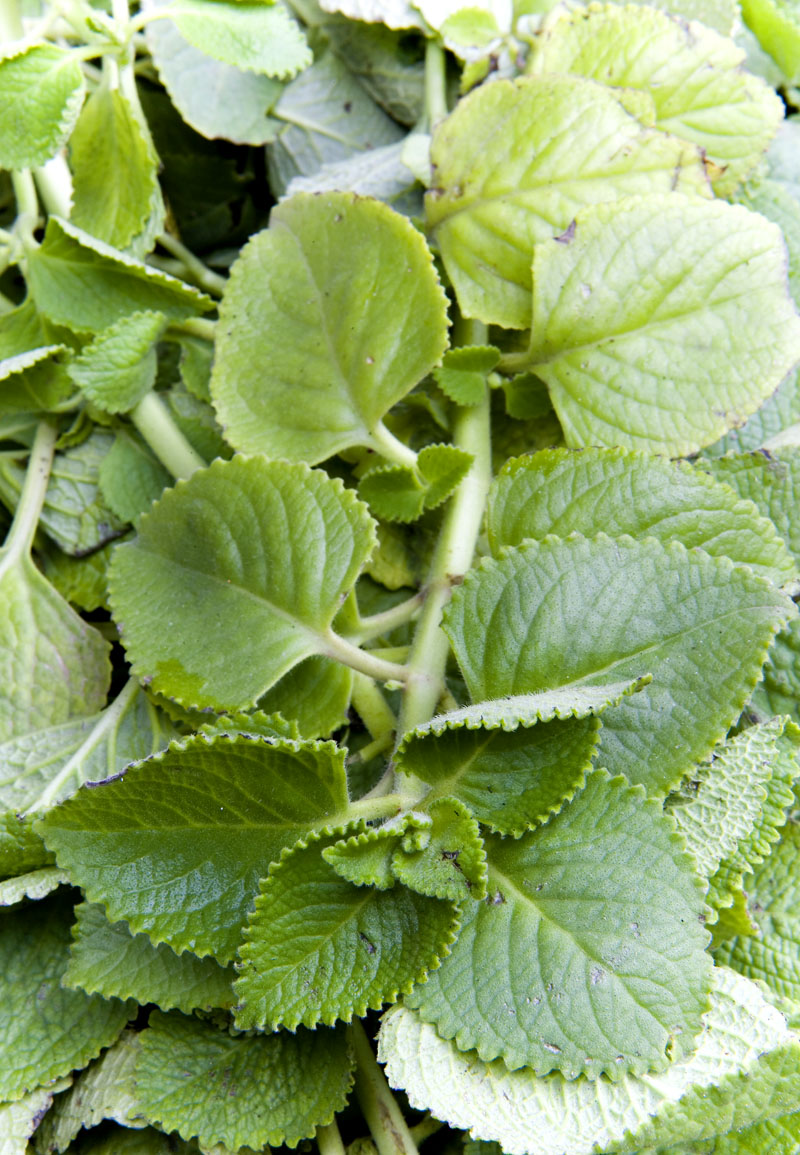

In [130]:
img = open_image('/content/indian borage1.jpg')
img

In [131]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category indian borage